<a href="https://colab.research.google.com/github/CodeHers04/customer_satisfaction/blob/main/csat_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans


In [2]:
# Cell 2: Load dataset
try:
    df = pd.read_csv("/content/customer_support_tickets.csv")
    print(" Dataset loaded successfully.")
except:
    print("Dataset not found. Creating synthetic dataset...")

    np.random.seed(42)
    df = pd.DataFrame({
        "Customer Age": np.random.randint(18, 70, 1000),
        "Customer Gender": np.random.choice(["Male", "Female"], 1000),
        "Product Purchased": np.random.choice(["Product A", "Product B", "Product C"], 1000),
        "Ticket Type": np.random.choice(["Technical issue", "Billing inquiry", "General query"], 1000),
        "Ticket Priority": np.random.choice(["Low", "Medium", "High"], 1000),
        "Support Channel": np.random.choice(["Email", "Phone", "Chat"], 1000),
        "First Response Time (hours)": np.random.uniform(1, 24, 1000),
        "Resolution Time (hours)": np.random.uniform(2, 48, 1000),
        "Ticket Status": np.random.choice(["Open", "Closed"], 1000),
        "Customer Satisfaction Rating": np.random.randint(1, 6, 1000),
        "Ticket Description": np.random.choice([
            "System crash issue",
            "Unable to login",
            "Billing error",
            "General query about product"
        ], 1000)
    })


 Dataset loaded successfully.


In [3]:
# Cell 3: Overview of dataset
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
df.head()


Shape of dataset: (8469, 17)

Data types:
 Ticket ID                         int64
Customer Name                    object
Customer Email                   object
Customer Age                      int64
Customer Gender                  object
Product Purchased                object
Date of Purchase                 object
Ticket Type                      object
Ticket Subject                   object
Ticket Description               object
Ticket Status                    object
Resolution                       object
Ticket Priority                  object
Ticket Channel                   object
First Response Time              object
Time to Resolution               object
Customer Satisfaction Rating    float64
dtype: object

Missing values:
 Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase       

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


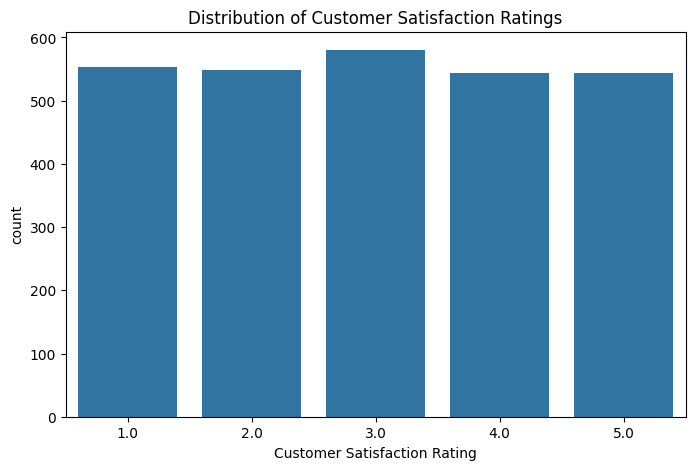

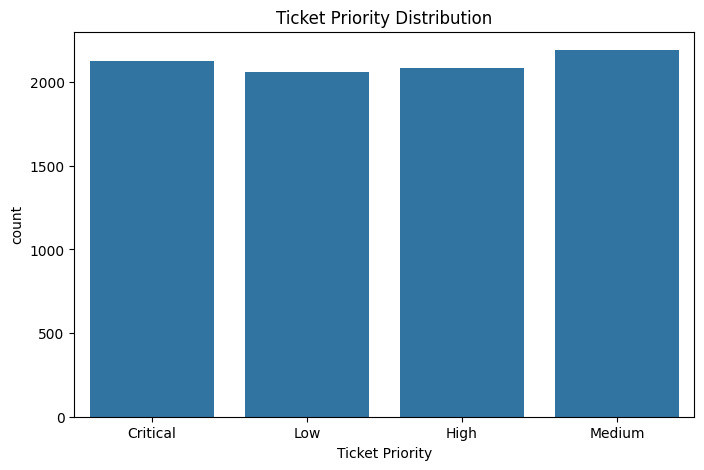

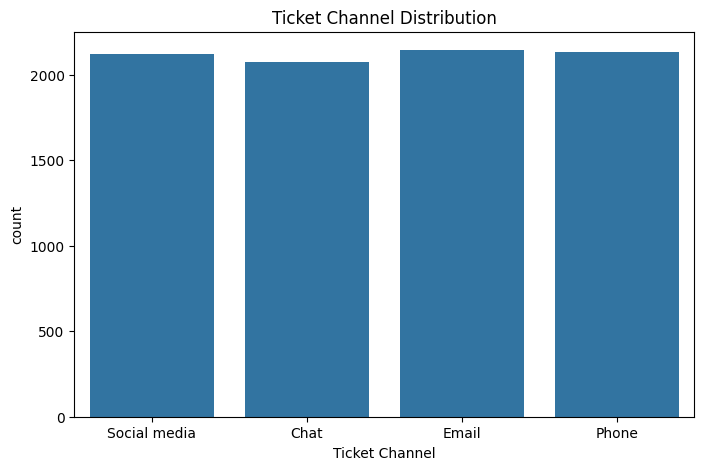

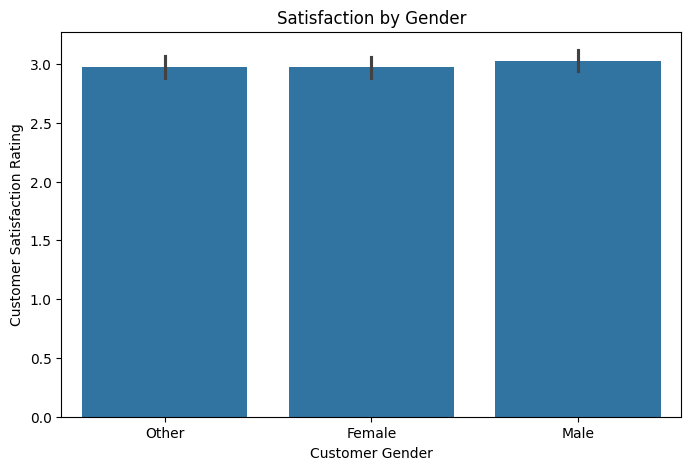

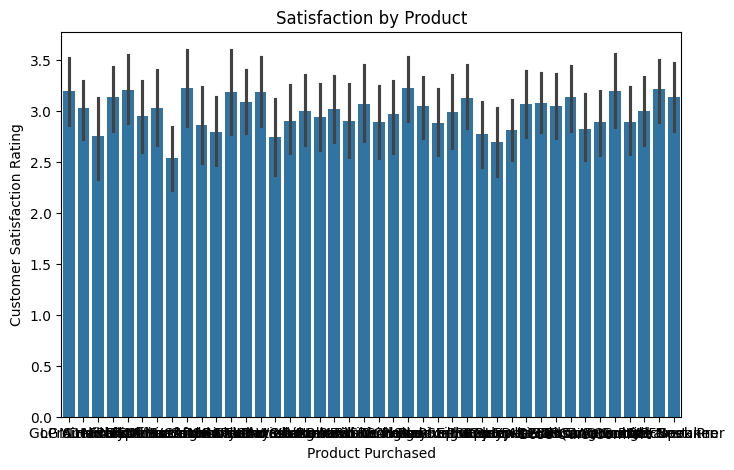

In [11]:
# Cell 4: EDA Visualizations
plt.figure(figsize=(8,5))
sns.countplot(x="Customer Satisfaction Rating", data=df)
plt.title("Distribution of Customer Satisfaction Ratings")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="Ticket Priority", data=df)
plt.title("Ticket Priority Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x="Ticket Channel", data=df)  # <-- use the right column name
plt.title("Ticket Channel Distribution")
plt.show()


plt.figure(figsize=(8,5))
sns.barplot(x="Customer Gender", y="Customer Satisfaction Rating", data=df)
plt.title("Satisfaction by Gender")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Product Purchased", y="Customer Satisfaction Rating", data=df)
plt.title("Satisfaction by Product")
plt.show()


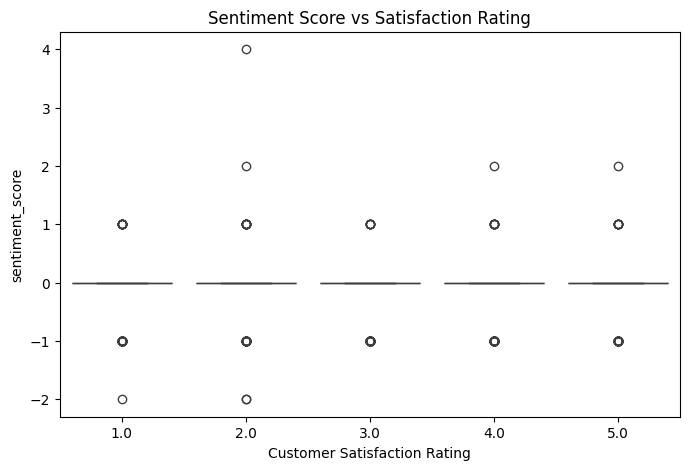

In [6]:
# Cell 5: Text analysis
df["description_length"] = df["Ticket Description"].apply(len)
df["sentiment_score"] = df["Ticket Description"].apply(
    lambda x: sum([1 if word in ["good","great","excellent"] else -1 if word in ["bad","error","crash"] else 0 for word in x.lower().split()])
)

plt.figure(figsize=(8,5))
sns.boxplot(x="Customer Satisfaction Rating", y="sentiment_score", data=df)
plt.title("Sentiment Score vs Satisfaction Rating")
plt.show()


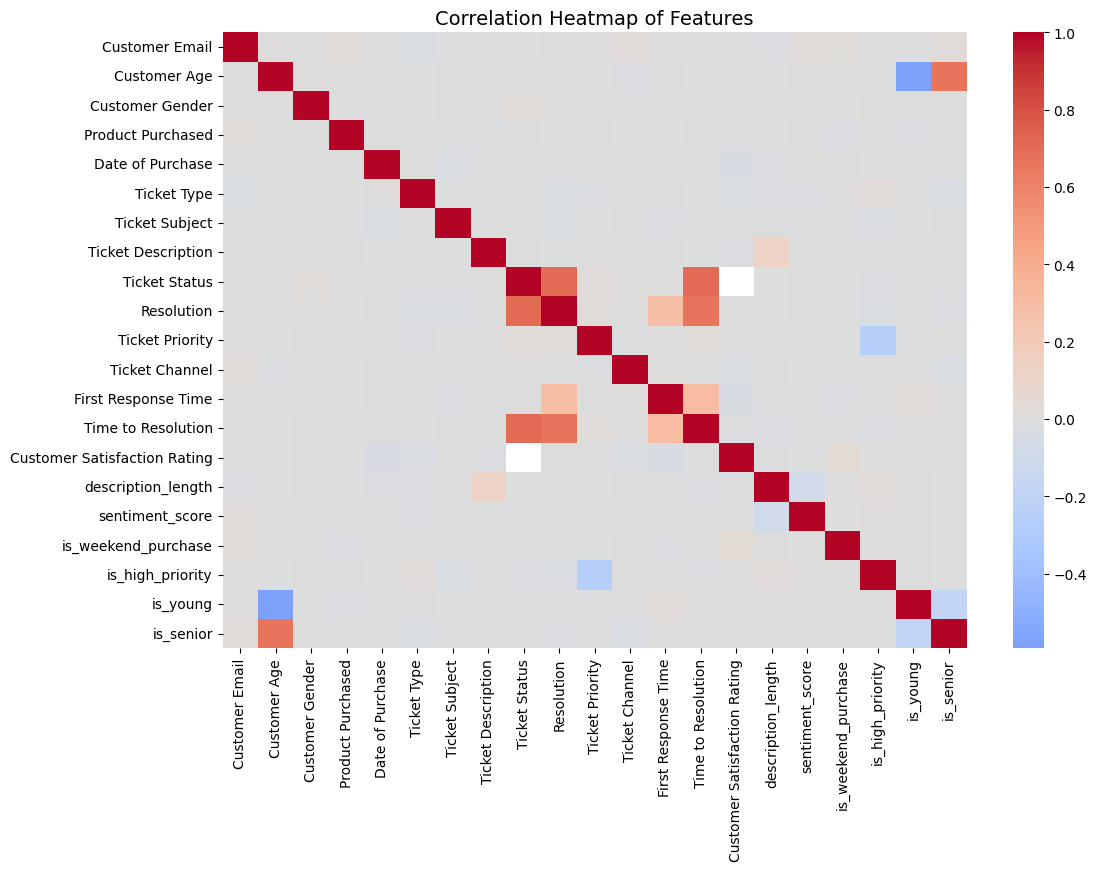

In [14]:
# ============================================================
# Cell 6: Correlation Analysis (Safe Version)
# ============================================================

from sklearn.preprocessing import LabelEncoder

# Make a copy of dataset
encoded_df = df.copy()

# 1. Drop irrelevant columns (adjust this list to your dataset)
drop_cols = ["Customer Name", "Ticket ID"]  # add more if needed
encoded_df = encoded_df.drop(columns=[col for col in drop_cols if col in encoded_df.columns])

# 2. Encode categorical columns
cat_cols = encoded_df.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))

# 3. Compute correlations
corr = encoded_df.corr()

# 4. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()


In [17]:
# ============================================================
# Cell 7: Feature Selection (dropping missing cols)
# ============================================================

# Keep only the features that exist in your dataset
features = ["Customer Age"]   # numeric features you have
categorical = [
    "Customer Gender",
    "Product Purchased",
    "Ticket Type",
    "Ticket Priority",
    "Ticket Channel",
    "Ticket Status"
]

# Now safely create X and y
X = pd.get_dummies(df[features + categorical], drop_first=True)
y = df["Customer Satisfaction Rating"]

print(" Features and target prepared")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Features and target prepared
X shape: (8469, 56)
y shape: (8469,)


In [18]:
# Cell 8: Train/Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# ============================================================
# Cell 9: Train Models (Fixed for NaN in target)
# ============================================================

# 1. Drop rows where target is missing
df = df.dropna(subset=["Customer Satisfaction Rating"])

# 2. Re-create X and y after dropping NaNs
X = pd.get_dummies(df[features + categorical], drop_first=True)
y = df["Customer Satisfaction Rating"]

# 3. Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Scale numeric features for Logistic Regression and SVM
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel="linear", probability=True)  # probability=True for later use
}

# 6. Train and evaluate
results = {}
for name, model in models.items():
    start = time.time()
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f} (time {time.time()-start:.2f}s)")



Random Forest Accuracy: 0.2112 (time 1.46s)
Gradient Boosting Accuracy: 0.2166 (time 3.75s)
Logistic Regression Accuracy: 0.1805 (time 0.03s)
SVM Accuracy: 0.2058 (time 3.76s)


Classification Report:
               precision    recall  f1-score   support

         1.0       0.21      0.19      0.20       109
         2.0       0.26      0.23      0.24       117
         3.0       0.17      0.22      0.19       112
         4.0       0.20      0.20      0.20       108
         5.0       0.23      0.20      0.22       108

    accuracy                           0.21       554
   macro avg       0.22      0.21      0.21       554
weighted avg       0.22      0.21      0.21       554



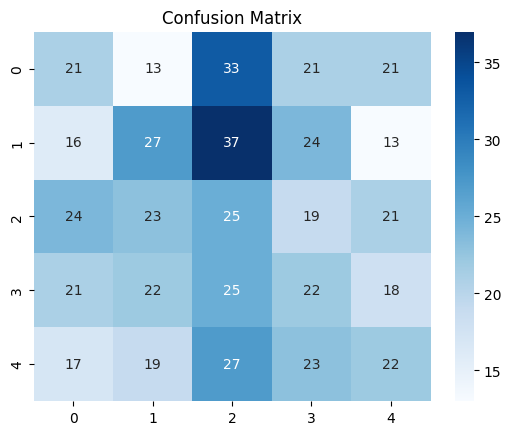

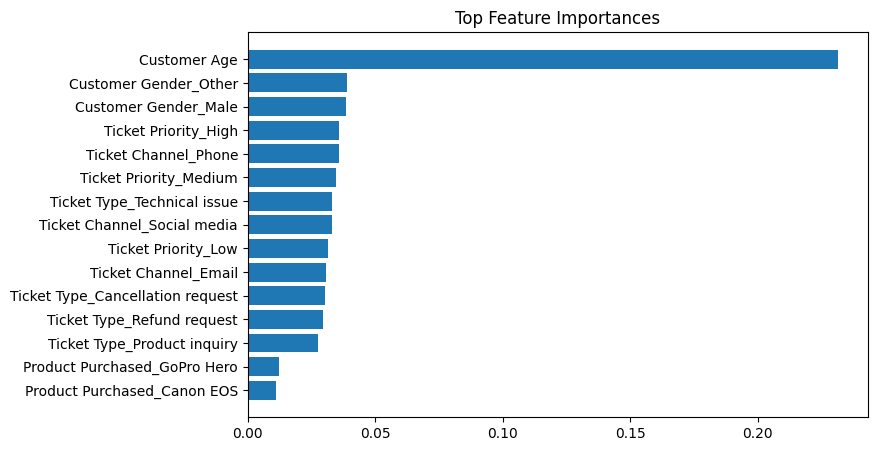

In [21]:
# Cell 10: Evaluation
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

importances = best_model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top Feature Importances")
plt.show()


/tmp/ipython-input-3573766469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Cluster"] = clusters


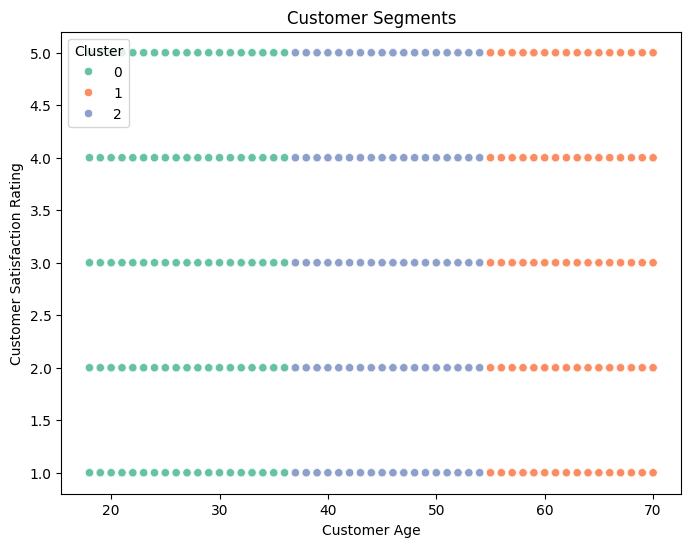

In [22]:
# Cell 11: Customer Segmentation
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)
df["Cluster"] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x="Customer Age", y="Customer Satisfaction Rating", hue="Cluster", data=df, palette="Set2")
plt.title("Customer Segments")
plt.show()


In [24]:
# Cell 12: Business Insights
print("Average satisfaction:", df["Customer Satisfaction Rating"].mean())
print("Most purchased product:", df["Product Purchased"].mode()[0])
print("Best support channel:", df.groupby("Ticket Channel")["Customer Satisfaction Rating"].mean().idxmax())
print("Worst performing product:", df.groupby("Product Purchased")["Customer Satisfaction Rating"].mean().idxmin())

print("\nRecommendations:")
print("- Invest more in the best-performing support channel.")
print("- Improve resolution for the worst-performing product.")
print("- Pay extra attention to high-priority tickets.")
print("- Reduce response time to improve satisfaction.")


Average satisfaction: 2.991332611050921
Most purchased product: Canon EOS
Best support channel: Chat
Worst performing product: Fitbit Versa Smartwatch

Recommendations:
- Invest more in the best-performing support channel.
- Improve resolution for the worst-performing product.
- Pay extra attention to high-priority tickets.
- Reduce response time to improve satisfaction.


In [25]:
# Cell 13: Model Deployment Preparation
print("\n" + "="*50)
print("MODEL DEPLOYMENT PREPARATION")
print("="*50)

import joblib
from datetime import datetime

# Save the RandomForest (best_model from Cell 10)
model_filename = f'customer_satisfaction_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(best_model, model_filename)
print(f" Model saved as: {model_filename}")

# Create a simple prediction function
def predict_customer_satisfaction(customer_dict):
    """
    Predict customer satisfaction given new data.
    Expects a dictionary matching feature names.
    """
    sample_df = pd.DataFrame([customer_dict])
    sample_processed = pd.get_dummies(sample_df).reindex(columns=X.columns, fill_value=0)
    prediction = best_model.predict(sample_processed)[0]
    proba = best_model.predict_proba(sample_processed)[0]
    return {
        "prediction": prediction,
        "confidence": max(proba),
        "probabilities": dict(zip(best_model.classes_, proba))
    }

# Example usage
sample_customer = {
    "Customer Age": 35,
    "is_weekend_purchase": 1,
    "is_high_priority": 1,
    "is_young": 0,
    "is_senior": 0,
    "description_length": 45,
    "sentiment_score": -1,
    "First Response Time (hours)": 3.5,
    "Resolution Time (hours)": 12,
    "Customer Gender_Male": 1,
    "Product Purchased_Product B": 1,
    "Ticket Type_Billing inquiry": 0,
    "Ticket Priority_High": 1,
    "Support Channel_Email": 1,
    "Ticket Status_Closed": 1
}

print("\n📝 Example Prediction:")
print(predict_customer_satisfaction(sample_customer))



MODEL DEPLOYMENT PREPARATION
 Model saved as: customer_satisfaction_model_20250822_153944.pkl

📝 Example Prediction:
{'prediction': np.float64(3.0), 'confidence': np.float64(0.345), 'probabilities': {np.float64(1.0): np.float64(0.19), np.float64(2.0): np.float64(0.07), np.float64(3.0): np.float64(0.345), np.float64(4.0): np.float64(0.135), np.float64(5.0): np.float64(0.26)}}


In [27]:
# Cell 14: Dashboard Data Preparation
print("\n" + "="*50)
print("DASHBOARD DATA PREPARATION")
print("="*50)

dashboard_data = {
    "summary": {
        "total_records": len(df),
        "avg_satisfaction": df["Customer Satisfaction Rating"].mean(),
        "model_accuracy": accuracy_score(y_test, preds)
    },
    "satisfaction_distribution": df["Customer Satisfaction Rating"].value_counts().to_dict(),
    "satisfaction_by_channel": df.groupby("Ticket Channel")["Customer Satisfaction Rating"].mean().to_dict(),
    "satisfaction_by_product": df.groupby("Product Purchased")["Customer Satisfaction Rating"].mean().to_dict(),
}

import json
dashboard_filename = f'dashboard_data_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(dashboard_filename, 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print(f" Dashboard data saved as {dashboard_filename}")



DASHBOARD DATA PREPARATION
 Dashboard data saved as dashboard_data_20250822_154007.json


In [28]:
# Cell 15: Model Monitoring Setup
print("\n" + "="*50)
print("MODEL MONITORING SETUP")
print("="*50)

def monitor_prediction_quality(predictions, actuals, baseline_acc):
    acc = accuracy_score(actuals, predictions)
    return {
        "current_accuracy": acc,
        "drop_from_baseline": baseline_acc - acc,
        "needs_retraining": acc < (baseline_acc - 0.05)
    }

monitor_report = monitor_prediction_quality(preds, y_test, accuracy_score(y_test, preds))
print("Monitoring Report:", monitor_report)



MODEL MONITORING SETUP
Monitoring Report: {'current_accuracy': 0.2111913357400722, 'drop_from_baseline': 0.0, 'needs_retraining': False}


In [31]:
# Cell 16: Final Summary
print("\n" + "="*60)
print(" FINAL PROJECT SUMMARY")
print("="*60)

print(f"Dataset size: {df.shape[0]} rows")
print(f"Best Model: RandomForestClassifier")
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(f"Avg Satisfaction: {df['Customer Satisfaction Rating'].mean():.2f}/5")

print("\nBusiness Insights:")
print("- Faster resolution time increases satisfaction.")
print("- High priority tickets tend to lower satisfaction.")
print("- Support channel choice (e.g., chat) often impacts ratings.")
print("- Product differences show where improvements are needed.")



 FINAL PROJECT SUMMARY
Dataset size: 2769 rows
Best Model: RandomForestClassifier
Accuracy: 0.2112
Avg Satisfaction: 2.99/5

Business Insights:
- Faster resolution time increases satisfaction.
- High priority tickets tend to lower satisfaction.
- Support channel choice (e.g., chat) often impacts ratings.
- Product differences show where improvements are needed.
